In [1]:
!pip install awswrangler --quiet
#!pip install s3fs -U --quiet

In [2]:
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pyarrow as pa
import pyarrow.parquet as pq

# Especificar la ruta del archivo Parquet en el bucket de S3
s3_path = 's3://agb-prueba-bucket/Covid Data.parquet'

# Leer el archivo Parquet desde S3
covid_data = pd.read_parquet(s3fs.S3FileSystem().open(s3_path))

In [3]:
covid_data.head(5)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [4]:
covid_data.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [5]:
covid_data['ICU'].value_counts()

97    848544
2     175685
1      16858
99      7488
Name: ICU, dtype: int64

In [6]:
covid_data["DEATH"] = [1 if each == "9999-99-99" else 0 for each in covid_data.DATE_DIED]
covid_data.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,1,2,2,2,2,2,3,97,0
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,1,2,2,1,1,2,5,97,0
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,3,2,0
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,7,97,0
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,1,2,2,2,2,2,3,97,0


In [7]:
covid_data = covid_data.drop(labels=["DATE_DIED"],axis=1)

covid_data.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU', 'DEATH'],
      dtype='object')

In [8]:
covid_data_sc = covid_data.drop(labels=["CLASIFFICATION_FINAL"],
                    axis=1)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/

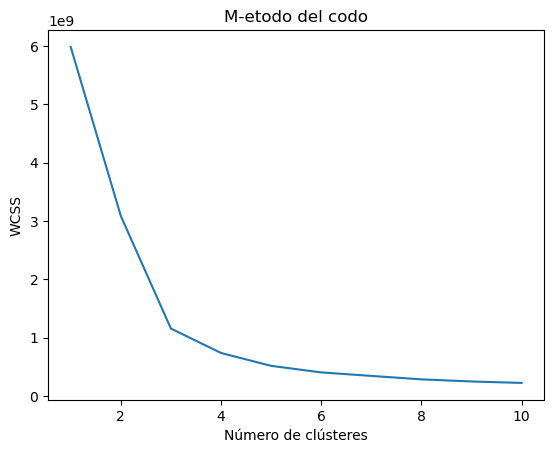

In [10]:
wcss = []
for i in range(1, 11):
    kmeans_prueba = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_prueba.fit(covid_data_sc)
    wcss.append(kmeans_prueba.inertia_)

# Grafica de la suma de las distancias
plt.plot(range(1, 11), wcss)
plt.title('M-etodo del codo')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [12]:
kmeans_classes = kmeans.fit_predict(covid_data_sc)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
covid_data.head(5)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,2,1,1,1,97,1,65,2,2,2,...,2,1,2,2,2,2,2,3,97,0
1,2,1,2,1,97,1,72,97,2,2,...,2,1,2,2,1,1,2,5,97,0
2,2,1,2,2,1,2,55,97,1,2,...,2,2,2,2,2,2,2,3,2,0
3,2,1,1,1,97,2,53,2,2,2,...,2,2,2,2,2,2,2,7,97,0
4,2,1,2,1,97,2,68,97,1,2,...,2,1,2,2,2,2,2,3,97,0


In [14]:
covid_data["CLASIFFICATION_FINAL"] = kmeans_classes

In [15]:
covid_data.head(5)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,2,1,1,1,97,1,65,2,2,2,...,2,1,2,2,2,2,2,1,97,0
1,2,1,2,1,97,1,72,97,2,2,...,2,1,2,2,1,1,2,0,97,0
2,2,1,2,2,1,2,55,97,1,2,...,2,2,2,2,2,2,2,2,2,0
3,2,1,1,1,97,2,53,2,2,2,...,2,2,2,2,2,2,2,1,97,0
4,2,1,2,1,97,2,68,97,1,2,...,2,1,2,2,2,2,2,0,97,0


In [16]:
s3_url_etiquetado = "s3://agb-prueba-bucket/Covid Data Etiquetado.parquet"

covid_data.to_parquet(s3_url_etiquetado,
                      compression='snappy',
                      engine = 'pyarrow')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [17]:
X = covid_data.drop(labels=["DEATH"],axis=1)
Y = covid_data["DEATH"]

In [18]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada
model.add(Dense(16, activation='relu'))  # Capa oculta
model.add(Dense(1, activation='sigmoid'))  # Capa de salida

2024-03-05 15:17:54.480473: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
26215/26215 [==============================] - 59s 2ms/step - loss: 0.1433 - accuracy: 0.9384
Epoch 2/10
26215/26215 [==============================] - 50s 2ms/step - loss: 0.1294 - accuracy: 0.9447
Epoch 3/10
26215/26215 [==============================] - 52s 2ms/step - loss: 0.1249 - accuracy: 0.9451
Epoch 4/10
26215/26215 [==============================] - 54s 2ms/step - loss: 0.1238 - accuracy: 0.9455
Epoch 5/10
26215/26215 [==============================] - 52s 2ms/step - loss: 0.1230 - accuracy: 0.9458
Epoch 6/10
26215/26215 [==============================] - 52s 2ms/step - loss: 0.1227 - accuracy: 0.9456
Epoch 7/10
26215/26215 [==============================] - 50s 2ms/step - loss: 0.1222 - accuracy: 0.9458
Epoch 8/10
26215/26215 [==============================] - 54s 2ms/step - loss: 0.1217 - accuracy: 0.9458
Epoch 9/10
26215/26215 [==============================] - 53s 2ms/step - loss: 0.1213 - accuracy: 0.9461
Epoch 10/10
26215/26215 [==============================

In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión del modelo: {accuracy * 100.0}%')

6554/6554 [==============================] - 10s 1ms/step - loss: 0.1208 - accuracy: 0.9467
Precisión del modelo: 94.6708619594574%
